# DSCI 571 - Supervised Learning I

# Lab 2: Preprocessing and building a simple ML pipeline

## Table of Contents

- [Submission instructions](#si)
- [Introduction](#in)
- [Exercise 1: Introducing the dataset](#1)
- [Exercise 2: Exploratory data analysis (EDA)](#2)
- [Exercise 3: Preprocessing and pipelines](#3)
- [Exercise 4: Building models](#4)
- [Exercise 5: Evaluating on the test set](#5)

In [1]:
# Import libraries
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:5}

You will receive marks for correctly submitting this assignment. 

To correctly submit this assignment follow the instructions below:

- Push your assignment to your GitHub repository. 
- Add a link to your GitHub repository here: LINK TO YOUR GITHUB REPO 
- Upload an HTML render of your assignment to Canvas. The last cell of this notebook will help you do that.
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).

[Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.

**NOTE: The data you download for use in this lab SHOULD NOT BE PUSHED TO YOUR REPOSITORY. You might be penalised for pushing datasets to your repository. I have seeded the repository with `.gitignore` and hoping that it won't let you push CSVs.**

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This lab will give you some practice to build a preliminary supervised machine learning pipeline on a real-world dataset. 

## Exercise 1: Introducing the dataset <a name="1"></a>
<hr>


In this lab you will be working on a sample of [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` locally in the lab folder. The repository is seeded with `.gitignore *.csv`. So you won't be able to push the CSV in your repository. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` in this folder). 

*Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary.*

In [2]:
### BEGIN STARTER CODE

# For the purpose of this lab, I am undersampling the dataset so that the labels are balanced.
# We'll learn about dealing with unbalanced data in DSCI 573.
adult_df_large = pd.read_csv("adult.csv")
g50k = adult_df_large[adult_df_large["income"] == ">50K"]
leq50k_sample = adult_df_large[adult_df_large["income"] == "<=50K"].sample(
    g50k.shape[0]
)
census_df = pd.concat([g50k, leq50k_sample])
census_df.shape

### END STARTER CODE

(15682, 15)

### 1.1 Data splitting 
rubric={accuracy:2}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (80%) and `test_df` (20%). Keep the target column (`income`) in the splits so that we can use it in EDA. 


In [3]:
### BEGIN SOLUTION

train_df, test_df = train_test_split(census_df, test_size=0.2, random_state=42)

### END SOLUTION

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [4]:
### BEGIN STARTER CODE

train_df.sort_index().head()

### END STARTER CODE

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K
10,45,Private,172274,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,>50K
12,52,Private,129177,Bachelors,13,Widowed,Other-service,Not-in-family,White,Female,0,2824,20,United-States,>50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.NaN` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [5]:
### BEGIN STARTER CODE

train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)

### END STARTER CODE

In [6]:
train_df_nan.shape

(12545, 15)

### 2.1 Numeric vs. categorical features
rubric={reasoning:5}

**Your tasks:**

1. Identify numeric and categorical features and create lists for each of them. 
2. Are there any features which are neither numeric nor categorical in this dataset? If yes, create a separate list for those features. 

In [7]:
### BEGIN STATER_CODE

# Fill in the lists below.
numeric_features = []
categorical_features = []
remainder_features = []

### END STATER_CODE

In [8]:
### BEGIN SOLUTION
# Let's identify numeric and categorical features

numeric_features = [
    "age",
    "fnlwgt",
    "education.num",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
]

categorical_features = [
    "workclass",
    "education",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native.country",
]

### END SOLUTION

### BEGIN SOLUTION

Note: For the purpose of this lab the above categorization is fine. It's also OK if you have categorized them further. For instance, it makes sense to consider education feature as an ordinal feature. Actually, they have given us education.num, where they have applied ordinal encoding. We'll talk more about this data in class. 

### END SOLUTION

### 2.2 Visualizing features
rubric={viz:4,reasoning:2}

**Your tasks**
1. Use `train_df_nan.info()` method to describe information of each feature and `train_df_nan.describe()` using the `include="all"` argument to show summary statistics of each feature. 
2. Visualize the histograms of numeric features using either `altair` or pandas plotting. 
3. Which features seem relevant for the given prediction task? 

You don't have to but you are welcome to use `pandas_profiling` for more elaborate visualization and EDA. 

In [9]:
### BEGIN SOLUTION

train_df.info()

### END SOLUTION

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12545 entries, 21103 to 29534
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             12545 non-null  int64 
 1   workclass       12545 non-null  object
 2   fnlwgt          12545 non-null  int64 
 3   education       12545 non-null  object
 4   education.num   12545 non-null  int64 
 5   marital.status  12545 non-null  object
 6   occupation      12545 non-null  object
 7   relationship    12545 non-null  object
 8   race            12545 non-null  object
 9   sex             12545 non-null  object
 10  capital.gain    12545 non-null  int64 
 11  capital.loss    12545 non-null  int64 
 12  hours.per.week  12545 non-null  int64 
 13  native.country  12545 non-null  object
 14  income          12545 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.5+ MB


In [10]:
### BEGIN SOLUTION

train_df.describe()

### END SOLUTION

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,12545.000000,1.254500e+04,12545.000000,12545.000000,12545.000000,12545.000000
mean,40.604544,1.882130e+05,10.616740,2104.516859,123.365963,42.133519
std,12.952773,1.030161e+05,2.605878,10575.264270,478.927789,12.104843
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,31.000000,1.178020e+05,9.000000,0.000000,0.000000,40.000000
50%,40.000000,1.770570e+05,10.000000,0.000000,0.000000,40.000000
75%,49.000000,2.348540e+05,13.000000,0.000000,0.000000,50.000000
max,90.000000,1.226583e+06,16.000000,99999.000000,4356.000000,99.000000


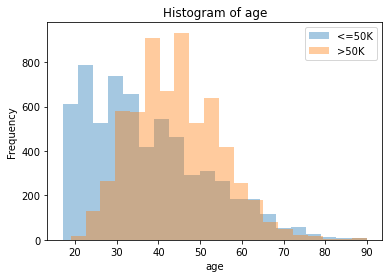

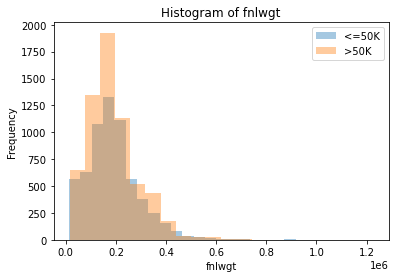

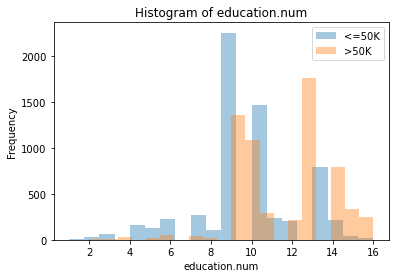

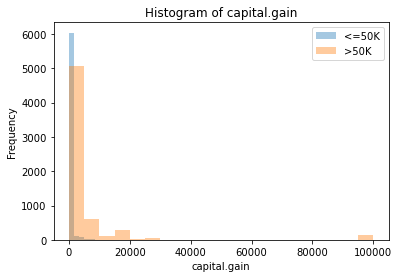

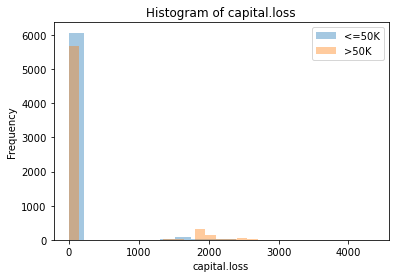

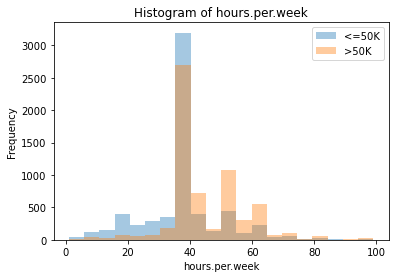

In [11]:
### BEGIN SOLUTION

for feat in numeric_features:
    ax = train_df.groupby("income")[feat].plot.hist(bins=20, alpha=0.4, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

### END SOLUTION

### BEGIN SOLUTION

Age and education features seem to be promising features. 

### END SOLUTION

### 2.3 Separating feature vectors and targets  
rubric={accuracy:2,reasoning:2}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df_nan` and `test_df_nan`. 
2. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not?

In [12]:
### BEGIN SOLUTION

X_train = train_df_nan.drop(columns=["income"])
y_train = train_df_nan["income"]

X_test = test_df_nan.drop(columns=["income"])
y_test = test_df_nan["income"]

### END SOLUTION

### BEGIN SOLUTION

It won't work at this point because our data is not preprocessed yet; we have some categorical columns and some NaN values in numeric columns. We need to preprocess it first before feeding it into ML algorithms. 

### END SOLUTION

## Exercise 3: Preprocessing <a name="3"></a>
<hr>

In this exercise you'll be wrangling the dataset so that it's suitable to be used with `scikit-learn` classifiers. 

### 3.1 Identifying transformations that need to be applied
rubric={reasoning:7}

**Your tasks:**

1. Identify the columns on which transformations need to be applied and tell us what transformation you would apply in what order by filling in the table below. Example transformations are shown for the feature `age` in the table.  
2. Are there any columns where no transformations need to be applied? 

### BEGIN STARTED CODE
| Feature | Transformation |
| --- | ----------- |
| age | imputation, scaling |
| workclass |  |
| fnlwgt |  |
| education |  |
| education.num |  |
| marital.status |  |
| occupation |  |
| relationship |  |
| race |  |
| sex |  |
| capital.gain |  |
| capital.loss |  |
| hours.per.week |  |
| native.country |  |

### END STARTED CODE

### BEGIN SOLUTION

- all features: Imputing unknown values using `SimpleImputer`
- numeric features: Scaling using `StandardScaler` 
- categorical features: One-hot-encoding using `OneHotEncoder`

| Feature | Transformation |
| --- | ----------- |
| age | imputation, scaling |
| workclass | imputation, OHE |
| fnlwgt | imputation, scaling |
| education | imputation, OHE |
| education.num | imputation, scaling |
| marital.status | imputation, OHE  |
| occupation | imputation, OHE  |
| relationship | imputation, OHE  |
| race | imputation, OHE  |
| sex | imputation, OHE  |
| capital.gain | imputation, scaling |
| capital.loss | imputation, scaling |
| hours.per.week | imputation, scaling |
| native.country | imputation, OHE |


### END SOLUTION

### 3.2 Imputing missing values **without** `sklearn.pipeline.Pipeline`
rubric={accuracy:5,reasoning:2}

In this exercise you'll be imputing missing values **without using `scikit-learn` pipelines**. The goal here is two-fold. First, to understand what happens under the hood when you use `scikit-learn` `Pipelines`, and second, to convince yourself why it's a good idea to use pipelines.  

**Your tasks:**
1. For numeric features, use [`scikit-learn`'s `SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to impute `NaN` values with `strategy="median"`. Remember to apply the transformations on both the train and test splits.  
2. For categorical features, use [`scikit-learn`'s `SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to impute `NaN` values by a constant string "missing". Remember to apply the transformations on both the train and test splits.
3. Show train split of categorical features in a dataframe after transforming the missing values. Do you see imputed missing values in the dataframe?  
4. When using the `SimpleImputer` transformer on the numeric columns, is there any problem with calling `fit_transform` on the test split? Why or why not? 

In [13]:
### BEGIN SOLUTION

# Impute numeric missing values by the median
imp = SimpleImputer(strategy="median")
X_num_train = imp.fit_transform(X_train[numeric_features])
X_num_test = imp.transform(X_test[numeric_features])

# Impute categorical missing values by a constant string
imp = SimpleImputer(strategy="constant", fill_value="missing")
X_cat_train = imp.fit_transform(X_train[categorical_features])
X_cat_test = imp.transform(X_test[categorical_features])

### END SOLUTION

In [14]:
### BEGIN SOLUTION

X_train

### END SOLUTION

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
21103,58,Self-emp-not-inc,130714,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
1049,38,Private,184655,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1740,48,United-States
32255,22,Local-gov,164775,5th-6th,3,Never-married,Handlers-cleaners,Other-relative,White,Male,0,0,40,Guatemala
23789,51,Private,355954,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States
32047,23,Private,263886,Some-college,10,Never-married,Sales,Not-in-family,Black,Female,0,0,20,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18742,41,Private,156566,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
11357,45,Self-emp-not-inc,160962,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,35,United-States
19721,44,NaN,109912,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,16,United-States
1606,42,Local-gov,175642,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,99999,0,40,United-States


In [15]:
### BEGIN SOLUTION

# Let's visualize the imputed values

pd.DataFrame(
    imp.transform(X_train[categorical_features]),
    columns=categorical_features,
    index=X_train.index,
)

### END SOLUTION

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
21103,Self-emp-not-inc,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
1049,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
32255,Local-gov,5th-6th,Never-married,Handlers-cleaners,Other-relative,White,Male,Guatemala
23789,Private,Some-college,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
32047,Private,Some-college,Never-married,Sales,Not-in-family,Black,Female,United-States
...,...,...,...,...,...,...,...,...
18742,Private,Some-college,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
11357,Self-emp-not-inc,Some-college,Never-married,Sales,Own-child,White,Female,United-States
19721,missing,Bachelors,Married-civ-spouse,missing,Wife,White,Female,United-States
1606,Local-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Female,United-States


### BEGIN SOLUTION

We see that the `NaN` values for workclass and occupation in the original data for row 19721 have been imputed.  

Yes, calling `fit_transform` on the test split when imputing missing values with `SimpleImputer` transformer is problematic, especially with numeric features. Here we are using the strategy of imputing values with the median value and if we call `fit` on test split, it'll impute the missing values with the median of the test examples and not train examples, which is a subtle violation of the golden rule. 

### END SOLUTION

### 3.3 One-hot encoding **without** `sklearn.pipeline.Pipeline`
rubric={accuracy:8,reasoning:4}     

**Your tasks:**

1. Apply one-hot encoding to the categorical features of imputed `X_train` and `X_test` from 3.2 using [`scikit-learn`'s `OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and show the new columns created using the `categories_` attribute of the `OneHotEncoder` object.
2. Create preprocessed train and test splits, `X_train_pp` and `X_test_pp`, by horizontally stacking transformed numeric columns from 3.2 and transformed categorical columns with imputation and OHE applied. 
3. What's the shape of `X_train_pp` and `X_test_pp`?
4. Carry out cross validation using `cross_validate` on the preprocessed `X_train_pp` and `y_train` using the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier) with default parameters. 
5. Are we violating the golden rule when we call `cross_validate` in 4.? Why or why not? 

In [16]:
### BEGIN SOLUTION

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_imp_ohe_train = ohe.fit_transform(X_cat_train)
X_imp_ohe_test = ohe.transform(X_cat_test)

# Now we have to put the Xs created by numeric and categorical
# transformations together
X_train_pp = np.hstack((X_num_train, X_imp_ohe_train))
X_test_pp = np.hstack((X_num_test, X_imp_ohe_test))

ohe.get_feature_names(categorical_features)
### END SOLUTION

array(['workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay',
       'workclass_missing', 'education_10th', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital.status_Divorced',
       'marital.status_Married-AF-spouse',
       'marital.status_Married-civ-spouse',
       'marital.status_Married-spouse-absent',
       'marital.status_Never-married', 'marital.status_Separated',
       'marital.status_Widowed', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occ

In [17]:
### BEGIN SOLUTION

transformed_ohe = pd.DataFrame(
    data=X_imp_ohe_train,
    columns=ohe.get_feature_names(categorical_features),
    index=X_train.index,
)

### END SOLUTION

In [18]:
transformed_ohe

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_missing,education_10th,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,native.country_missing
21103,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1049,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32255,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23789,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32047,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18742,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11357,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1606,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
### BEGIN SOLUTION

X_test_pp.shape

### END SOLUTION

(3137, 107)

In [20]:
### BEGIN SOLUTION

knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train_pp, y_train, return_train_score=True)
pd.DataFrame(scores)

### END SOLUTION

,fit_time,score_time,test_score,train_score
0,0.050617,0.108795,0.602631,0.745118
1,0.042934,0.108013,0.627342,0.737346
2,0.043825,0.108127,0.595855,0.743125
3,0.044410,0.115406,0.605819,0.742627
4,0.043664,0.106885,0.600638,0.749203


### BEGIN SOLUTION
Yes, we are breaking the golden rule here when we call `cross-validate` on preprocessed `X_train` and `y_train`. When carrying out preprocessing, we should apply `fit_transform` on the train split and only `transform` on the test split. If we pass preprocessed `X_train` to cross validation, the training phase would have some influence from the validation set. So we are subtly breaking the golden rule here. 
### END SOLUTION

### 3.4 Using `sklearn.pipeline.Pipeline`
rubric={accuracy:8,reasoning:2}

As noted in 3.2 and 3.3, when we want to apply a series of transformations, the code becomes unwieldy quite quickly. We can do this much more elegantly using [`scikit-learn` pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).   

Let's carry out preprocessing using pipelines now. Note that you can define pipelines in two ways: by using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and providing named steps or by using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) which allows for simplified pipeline construction. In the latter case, the names of the steps will be set to the lowercase of their types automatically. You may use the method of your choice.  


1. Define a `Pipeline` for numerical features with two steps: 
    - [`SimpleImputer()`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) with `strategy = "median"` 
    - [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
2. Define a `Pipeline` for categorical features with two steps: 
    - [`SimpleImputer()`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) with `strategy = "constant"`
    - [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) with `handle_unknown="ignore"`

3. Define a [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) called `preprocessor` for the numerical, categorical, and remainder features.
4. Fit the `preprocessor` on `X_train` and `y_train`.
5. Examine the new features created by the `OneHotEncoder`. How many new features are created for the categorical feature `marital.status`?

In [21]:
### BEGIN SOLUTION

# Let's build a pipeline for our dataset
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
### END SOLUTION

In [22]:
### BEGIN SOLUTION

preprocessor.fit(X_train, y_train)
ohe_feature_names = list(
    preprocessor.named_transformers_["cat"]
    .named_steps["onehotencoder"]
    .get_feature_names(categorical_features)
)
marital_status_ohe_feats = [
    feature for feature in ohe_feature_names if feature.startswith("marital")
]
print(
    "The number of features created for marital.status feature: %d"
    % (len(marital_status_ohe_feats))
)

print("And the features are:\n", "\n".join(marital_status_ohe_feats))

### END SOLUTION

The number of features created for marital.status feature: 7
And the features are:
 marital.status_Divorced
marital.status_Married-AF-spouse
marital.status_Married-civ-spouse
marital.status_Married-spouse-absent
marital.status_Never-married
marital.status_Separated
marital.status_Widowed


## Exercise 4: Building models <a name="4"></a>
<hr>

Now that we have preprocessed features, we are ready to build models. 

In [23]:
### BEGIN STARTER CODE

# Lets create an empty dictionary to store all the results
results_dict = {}

### END STARTER CODE

In [24]:
### BEGIN STARTER CODE

# You may use or adapt this function to keep your results organized
def store_cross_val_results(model_name, scores, results_dict):
    """
    Stores mean scores from cross_validate in results_dict for
    the given model model_name.

    Parameters
    ----------
    model_name :
        scikit-learn classification model
    scores : dict
        object return by `cross_validate`
    results_dict: dict
        dictionary to store results

    Returns
    ----------
        None

    """
    results_dict[model_name] = {
        "mean_train_accuracy": "{:0.4f}".format(np.mean(scores["train_score"])),
        "mean_validation_accuracy": "{:0.4f}".format(np.mean(scores["test_score"])),
        "mean_fit_time (s)": "{:0.4f}".format(np.mean(scores["fit_time"])),
        "mean_score_time (s)": "{:0.4f}".format(np.mean(scores["score_time"])),
        "std_train_score": "{:0.4f}".format(scores["train_score"].std()),
        "std_test_score": "{:0.4f}".format(scores["test_score"].std()),
    }


### END STARTER CODE

### 4.1 Building a baseline model 
rubric={accuracy:4}

**Your tasks:**
1. Define a pipeline with two steps: preprocessor from 3.4 and `scikit-learn`'s `DummyClassifier` with `strategy="prior"` as your classifier.  
2. Carry out 5-fold cross validation with the pipeline. Store the results in `results_dict` above. (You may use the function above `store_cross_val_results` to store the results.) 

In [25]:
### BEGIN SOLUTION

# Baseline model

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="prior")

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", dummy)])

scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
store_cross_val_results("dummy", scores, results_dict)

### END SOLUTION

### 4.2 Trying different classifiers
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: preprocessor from 3.4 and the model as your classifier.  
    - Carry out 5-fold cross validation with the pipeline using `cross_validate`.
    - Store the results in `results_dict`. (You may use the function above `store_cross_val_results` to store the results.) 
2. Display all the results so far as a dataframe. 
3. Compare the train and validation accuracies and `fit` and `score` times in each case. How do the the validation accuracies compare to the baseline model from 4.1? Which model has the best validation accuracy? Which model is the fastest one?  

In [26]:
### BEGIN STARTER CODE

models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

### END STARTER CODE

In [27]:
### BEGIN SOLUTION

for model_name, model in models.items():
    # print(model_name, ":")
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    scores = cross_validate(pipe, X_train, y_train, cv=5, return_train_score=True)
    store_cross_val_results(model_name, scores, results_dict)

### END SOLUTION

In [28]:
### BEGIN SOLUTION

results_df = pd.DataFrame(results_dict).T
results_df

### END SOLUTION

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score
dummy,0.5011,0.5011,0.0286,0.0098,0.0000,0.0002
decision tree,1.0000,0.7714,0.2249,0.0103,0.0000,0.0061
kNN,0.8551,0.7956,0.0304,0.8814,0.0016,0.0053
RBF SVM,0.8469,0.8289,2.3939,0.3801,0.0009,0.0038


### BEGIN SOLUTION
####  Observations
- SVC has the best validation performance, followed by KNN and then decision tree.  
- Decision tree is clearly overfitting. 
- kNN and SVM seem to be too slow compared to the decision tree. 
### END SOLUTION

### (optional) 4.3 Exploring importance of scaling
rubric={reasoning:1}

In this exercise you'll examine whether scaling helps in case of KNN and RBF SVM. 

**Your tasks:**

1. Create a column transformer without the `StandardScaler` step for `numeric_features`. 
2. Repeat the steps in 4.2 with this new column transformer. 
3. Compare the results with scaled numeric features with unscaled numeric features. Is scaling necessary for decision trees? Why or why not?

In [29]:
### BEGIN SOLUTION

numeric_transformer_unscaled = make_pipeline(SimpleImputer(strategy="median"))

preprocessor_unscaled = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_unscaled, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

for model_name, model in models.items():
    pipe_unscaled = Pipeline(
        steps=[("preprocessor", preprocessor_unscaled), ("classifier", model)]
    )
    scores = cross_validate(
        pipe_unscaled, X_train, y_train, cv=5, return_train_score=True
    )
    store_cross_val_results(model_name + "_unscaled", scores, results_dict)

results_df = pd.DataFrame(results_dict).T
results_df

### END SOLUTION

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score
dummy,0.5011,0.5011,0.0286,0.0098,0.0000,0.0002
decision tree,1.0000,0.7714,0.2249,0.0103,0.0000,0.0061
kNN,0.8551,0.7956,0.0304,0.8814,0.0016,0.0053
RBF SVM,0.8469,0.8289,2.3939,0.3801,0.0009,0.0038
decision tree_unscaled,1.0000,0.7728,0.2034,0.0098,0.0000,0.0054
kNN_unscaled,0.7435,0.6063,0.0294,0.8166,0.0039,0.0110
RBF SVM_unscaled,0.5808,0.5801,4.5012,0.7987,0.0011,0.0033


### BEGIN SOLUTION
####  Observations
- Scaling is clearly helping the distance-based classifiers kNN and SVM with RBF kernel. 
- It doesn't seem to have much impact on the decision tree classifier, which makes sense. In principle, tree-based algorithms should be indifferent to scaling and should be able to deal with nominal features. But the `scikit-learn` implementation of the decision tree algorithm requires numeric values for branching. 
### END SOLUTION

### 4.4 Hyperparameter optimization
rubric={accuracy:4,reasoning:2}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice you'll carry out hyperparameter optimization for all different hyperparameters for the most promising classifiers. For the purpose of this assignment, we'll only do it for our best performing `SVC` classifier with one hyperparameter, `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` in the starter code below: 
    - Create a pipeline object with two steps: preprocessor from 3.4 and SVC classifier with the value of `C`.
    - Carry out cross-validation using `cross_validate` and store results in the `results_dict` using the function `store_cross_val_results`. You may pass the `model_name` as `SVC` + the current `C` value. 
2. Which hyperparameter value seems to be performing the best? Is it different than the default value for the hyperparameter used by `scikit-learn`? 

In [30]:
### BEGIN STARTER CODE

param_grid = {"C": np.logspace(-3, 2, 6)}

### END STARTER CODE

In [31]:
### BEGIN SOLUTION

for param in param_grid["C"]:
    model_name = "RBF SVC"
    pipe = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", SVC(C=param))]
    )
    scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
    store_cross_val_results(
        model_name + " (C=" + str(param) + ")", scores, results_dict
    )

### END SOLUTION

In [32]:
### BEGIN SOLUTION

results_df = pd.DataFrame(results_dict).T
results_df

### END SOLUTION

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score
dummy,0.5011,0.5011,0.0286,0.0098,0.0000,0.0002
decision tree,1.0000,0.7714,0.2249,0.0103,0.0000,0.0061
kNN,0.8551,0.7956,0.0304,0.8814,0.0016,0.0053
RBF SVM,0.8469,0.8289,2.3939,0.3801,0.0009,0.0038
decision tree_unscaled,1.0000,0.7728,0.2034,0.0098,0.0000,0.0054
kNN_unscaled,0.7435,0.6063,0.0294,0.8166,0.0039,0.0110
RBF SVM_unscaled,0.5808,0.5801,4.5012,0.7987,0.0011,0.0033
RBF SVC (C=0.001),0.6753,0.6760,4.7499,0.8501,0.0050,0.0060
RBF SVC (C=0.01),0.7977,0.7957,3.4923,0.6141,0.0016,0.0024
RBF SVC (C=0.1),0.8205,0.8161,2.5057,0.4377,0.0016,0.0032


### BEGIN SOLUTION
The hyperparameter C = 1.0 is giving the best results, which is the default value for the hyperparameter in `scikit-learn`. (Well done `scikit-learn`!)  
### END SOLUTION

### (Optional) 4.5 Hyperparameter optimization of multiple parameters
rubric={reasoning:1}

In the previous exercise we carried out hyperparameter optimization of only one hyperparameter. But as we saw in class `SVC` has two important hyperparameters: `C` and `gamma` which may interact with each other and we need to optimize them both simultaneously.  

**Your tasks:**
1. Carry out hyperparameter optimization of `C` and `gamma` simultaneously for the param grid of your choice. 
2. Do you get a different value for `C` than in 4.4? 

**Note: The material required to answer this question is not covered this week. This block I am trying something new. In some of the labs I will be including an optional question which leads to the material in the upcoming week. It's a low-risk question and is worth only one point. The evaluation of this question is going to be pretty lenient. The intention here is not to get the perfect answer from you but to get you thinking about the upcoming material.**

In [38]:
### BEGIN SOLUTION

from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", SVC())])

param_grid = {
    "classifier__gamma": np.logspace(-3, 2, 6),
    "classifier__C": np.logspace(-3, 2, 6),
}

grid_search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)
print("best hyperparameters: ", grid_search.best_params_)
print("best crosss-validation score: %0.4f"%(grid_search.best_score_))

### END SOLUTION

best hyperparameters:  {'classifier__C': 1.0, 'classifier__gamma': 0.1}
best crosss-validation score: 0.8296


### BEGIN SOLUTION
In this particular case, the cross validation scores are a tiny bit better with `C=1.0` and `gamma=0.1` compared to the default hyperparameters of `sklearn`.
### END SOLUTION

## Exercise 5: Evaluating on the test set <a name="5"></a>
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 5.1 Scoring on the unseen test set 
rubric={accuracy:4,reasoning:4}

**Your tasks:**

1. Report the results on `X_test` for all classifiers. Pick the best hyperparameter from 4.4 for the SVC RBF classifier. 
2. Compare and discuss the train, validation, and test results of all classifiers. 

In [34]:
### BEGIN SOLUTION

models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(C=1.0),
}

for model_name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    pipe.fit(X_train, y_train)
    results_dict[model_name]["test_score"] = pipe.score(X_test, y_test)

### END SOLUTION

In [35]:
### BEGIN SOLUTION

results_df = pd.DataFrame(results_dict).T
results_df

### END SOLUTION

,mean_train_accuracy,mean_validation_accuracy,mean_fit_time (s),mean_score_time (s),std_train_score,std_test_score,test_score
dummy,0.5011,0.5011,0.0286,0.0098,0.0000,0.0002,NaN
decision tree,1.0000,0.7714,0.2249,0.0103,0.0000,0.0061,0.77877
kNN,0.8551,0.7956,0.0304,0.8814,0.0016,0.0053,0.796302
RBF SVM,0.8469,0.8289,2.3939,0.3801,0.0009,0.0038,0.823717
decision tree_unscaled,1.0000,0.7728,0.2034,0.0098,0.0000,0.0054,NaN
kNN_unscaled,0.7435,0.6063,0.0294,0.8166,0.0039,0.0110,NaN
RBF SVM_unscaled,0.5808,0.5801,4.5012,0.7987,0.0011,0.0033,NaN
RBF SVC (C=0.001),0.6753,0.6760,4.7499,0.8501,0.0050,0.0060,NaN
RBF SVC (C=0.01),0.7977,0.7957,3.4923,0.6141,0.0016,0.0024,NaN
RBF SVC (C=0.1),0.8205,0.8161,2.5057,0.4377,0.0016,0.0032,NaN


### BEGIN SOLUTION

Observations
- The test results are more or less consistent with the validation results. 
- All classifiers are performing better than the dummy classifier.
- Scaling is clearly helping the distance-based classifiers kNN and SVM with RBF kernel. But it doesn't seem to have much impact on the decision tree classifier, which makes sense.
- The decision tree classifier is the fastest one. But it's clearly overfitting; the training accuracy is perfect but the validation and test accuracy is much lower.
- KNN is performing better than decision tree but it's much slower. 
- SVM with RBF kernel with `sklearn`'s default hyperparameters is the best performing classifier (0.82 test accuracy) among the classifiers we have tried. It's much slower compared to decision tree but a bit faster than kNN. 
### END SOLUTION

### Submission to Canvas

**PLEASE READ: When you are ready to submit your assignment do the following:**

- Run all cells in your notebook to make sure there are no errors by doing Kernel -->  Restart Kernel and Run All Cells...
- If you are using the "571" `conda` environment, make sure to select it before running all cells. 
- Convert your notebook to .html format using the `convert_notebook()` function below or by File -> Export Notebook As... -> Export Notebook to HTML
- Run the code `submit()` below to go through an interactive submission process to Canvas.
After submission, be sure to do a final push of all your work to GitHub (including the rendered html file).

In [36]:
# from canvasutils.submit import convert_notebook, submit

# convert_notebook("lab1.ipynb", "html")  # uncomment and run when you want to try convert your notebook (or you can convert manually from the File menu)
# submit(course_code=53670, token=False)  # uncomment and run when ready to submit to Canvas

### Congratulations on finishing the lab! Now you are ready to build a simple ML pipeline on real-world datasets! Well done :clap:! 